In [1]:
import sys
sys.path.append('./scripts/')
from dp_policy_agent import *
from dynamic_programming import *
from mcl import *

In [2]:
class HazardQmdpAgent(DpPolicyAgent): ###qmdp3
    def __init__(self, time_interval, estimator, goal, puddles, sampling_num=10, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 puddle_coef=1000000.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): 
        super().__init__(time_interval, estimator, goal, puddle_coef, widths, lowerleft, upperright)
        
        self.dp = DynamicProgramming(widths, goal, puddles, time_interval, sampling_num, puddle_coef)
        self.dp.value_function = self.init_value()
        self.obs_value_function = self.init_obs_value()
        self.evaluations = np.array([0.0, 0.0, 0.0])
        self.current_value = 0.0
        
        self.history = [(0, 0)] #行動の履歴を記録
        
        self.memo = ""
        
  #      self.current_mode = "goal"
        
    def init_obs_value(self):
        tmp = np.zeros(self.dp.index_nums)
        for line in open("./data/dp_observation_value.txt", "r"):
            d = line.split()
            tmp[int(d[0]), int(d[1]), int(d[2])] = float(d[3])
            
        return tmp
        
    def init_value(self):
        tmp = np.zeros(self.dp.index_nums)
        for line in open("./data/dp_value.txt", "r"):
            d = line.split()
            tmp[int(d[0]), int(d[1]), int(d[2])] = float(d[3])
            
        return tmp
    
    def action_value(self, action, index, particle, vf, out_penalty=True):
        value = 0.0
        for delta, prob in self.dp.state_transition_probs[(action, index[2])]:
            after, out_reward = self.dp.out_correction(np.array(index).T + delta)
            after = tuple(after)
                
            reward = - self.dp.time_interval * self.dp.depths[(after[0], after[1])] * self.dp.puddle_coef - self.dp.time_interval + out_reward*out_penalty        
            value += (vf[after] + reward) * prob
            
        return value
    
    def evaluation(self, action, indexes, particles):
        indexnum = len(set(indexes))
        ps = list(zip(indexes, particles))
        
        if indexnum < 70:
            vf = self.dp.value_function
        else:
            vf = self.obs_value_function
        
        vs = [vf[e[0]] if vf[e[0]] < 0.0 else -1e-10 for e in ps]                        #PFCの式の分母
        qs = [self.action_value(action, e[0], e[1], vf, out_penalty=False) for e in ps]   #QMDPの値
        
    #    self.memo += " " + str( sum([q - v + self.dp.time_interval for (v,q) in zip(vs, qs)])/len(ps) )
        
        return sum([(q - v + self.dp.time_interval)/(v**2) for (v,q) in zip(vs, qs)])/len(ps) # @@@ゼロ割の恐れ@@@
        
    def policy(self, pose, goal=None): #追加（引数poseは使わない）        
        indexes = [self.to_index(p.pose, self.pose_min, self.index_nums, self.widths) for p in self.estimator.particles]
  
        self.current_value = sum([self.dp.value_function[i] for i in indexes])/len(indexes)
        self.evaluations = [self.evaluation(a, indexes, self.estimator.particles) for a in self.dp.actions]

        self.history.append(self.dp.actions[np.argmax(self.evaluations)])
        
        for p in self.estimator.particles:
            if self.dp.goal.inside(p.pose):
                p.weight *= 0.01

        if self.history[-1][0] + self.history[-2][0] == 0.0 and self.history[-1][1] + self.history[-2][1] == 0.0: #2回の行動で停止していたら前進
            return (1.0, 0.0)
        
        return self.history[-1]
    
    def draw(self, ax, elems):
        super().draw(ax, elems)
        elems.append(ax.text(-4.5, -4.6, "{:.3} => [{:.3}, {:.3}, {:.3}]".format(self.current_value, *self.evaluations), fontsize=8))
     #   elems.append(ax.text(-4.5, -3.6, "{} {}".format(self.current_mode, self.memo), fontsize=8))
        self.memo = ""

In [3]:
def trial(animation):
    time_interval = 0.1
    world = PuddleWorld(180, time_interval, debug=not animation) 

    ##ランドマークの追加（意地悪な位置に）##
    m = Map()
    for ln in [(1,4), (4,1), (-4,-4)]: m.append_landmark(Landmark(*ln))
    world.append(m) 
    
    ##ゴール・水たまりの追加（これは特に変更なし）##
    goal = Goal(-3,-3)
    puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)] 
    world.append(goal)
    world.append(puddles[0]) 
    world.append(puddles[1])
    
    ##ロボットを作る##
    init_pose = np.array([2.5, 2.5, 0]).T
    pf = Mcl(m, init_pose, 100)
    a = HazardQmdpAgent(time_interval, pf, goal, puddles,puddle_coef=1000000.0) 
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")

    world.append(r)
    world.draw()
  #  world.ani.save('/tmp/anm.gif', writer='imagemagick', fps=10)
    
    return a

<IPython.core.display.Javascript object>


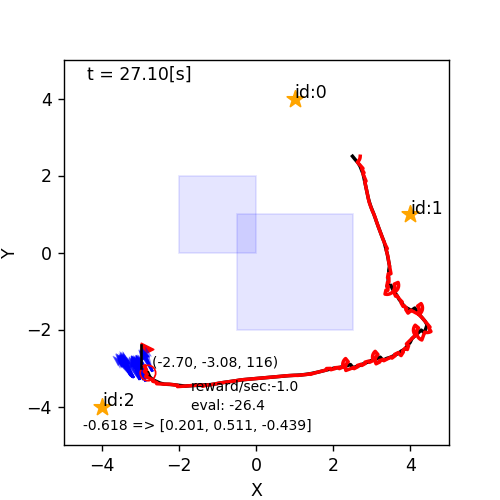

In [4]:
trial(True)

In [5]:
def evaluation():
    with open("pfc_propose_result.txt", "w") as f:
        num = 1000
        for i in range(num):
            a = trial(False)
            f.write("{} {}\n".format(a.total_reward+a.final_value, a.in_goal))
            f.flush()

In [6]:
evaluation()

./scripts/ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))
